# Assignment #2 - Convolutional Neural Networks

<font color="red"> <b> Due: Mar 23 (Sunday) 11:59 pm </b> </font>

<font color="yellow"> Jeffery Sengsy </font>

# 🌿 Plant Disease Early Detection

This project leverages deep learning and transfer learning with ResNet-50 to classify plant diseases using the PlantVillage dataset. The model helps in identifying whether a plant is healthy or suffering from a disease, aiding in early diagnosis and better crop management.

# 🗂 Data

"The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease."

This dataset is loacted in TensorFlow Datasets (TFDS) to load PlantVillage

https://www.tensorflow.org/datasets/catalog/plant_village

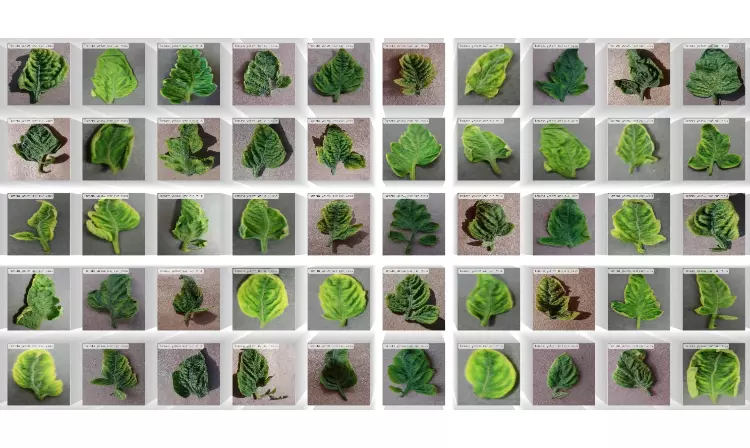


# Classes

The following 38 classes are availaible in the dataset:

<details>
  <summary>Click to expand</summary>

- `Apple___Apple_scab`
- `Apple___Black_rot`
- `Apple___Cedar_apple_rust`
- `Apple___healthy`
- `Blueberry___healthy`
- `Cherry_(including_sour)___Powdery_mildew`
- `Cherry_(including_sour)___healthy`
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot`
- `Corn_(maize)___Common_rust_`
- `Corn_(maize)___Northern_Leaf_Blight`
- `Corn_(maize)___healthy', 'Grape___Black_rot`
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)`
- `Grape___healthy`
- `Orange___Haunglongbing_(Citrus_greening)`
- `Peach___Bacterial_spot`
- `Peach___healthy`
- `Pepper,_bell___Bacterial_spot`
- `Pepper,_bell___healthy`
- `Potato___Early_blight`
- `Potato___Late_blight`
- `Potato___healthy`
- `Raspberry___healthy`
- `Soybean___healthy`
- `Squash___Powdery_mildew`
- `Strawberry___Leaf_scorch`
- `Strawberry___healthy`
- `Tomato___Bacterial_spot`
- `Tomato___Late_blight`
- `Tomato___Leaf_Mold`
- `Tomato___Septoria_leaf_spot`
- `Tomato___Spider_mites Two-spotted_spider_mite`
- `Tomato___Target_Spot`
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus`
- `Tomato___Tomato_mosaic_virus`
- `Tomato___healthy`






In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets,Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

print("TF version:", tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_datasets as tfds

TF version: 2.18.0


In [55]:
dataset, info = tfds.load("plant_village", as_supervised=True, with_info=True)

In [56]:
import collections
class_names = info.features["label"].names
num_classes = len(class_names)
label_counts = collections.defaultdict(int)

In [57]:
for _, label in tfds.as_numpy(dataset["train"]):
    label_counts[label] += 1

In [9]:
# Print class distribution
print("Class distribution before subsetting:")
for i, count in sorted(label_counts.items()):
    print(f"{class_names[i]}: {count}")

Class distribution before subsetting:
Apple___Apple_scab: 630
Apple___Black_rot: 621
Apple___Cedar_apple_rust: 275
Apple___healthy: 1645
Blueberry___healthy: 1502
Cherry___healthy: 854
Cherry___Powdery_mildew: 1052
Corn___Cercospora_leaf_spot Gray_leaf_spot: 513
Corn___Common_rust: 1192
Corn___healthy: 1162
Corn___Northern_Leaf_Blight: 985
Grape___Black_rot: 1180
Grape___Esca_(Black_Measles): 1383
Grape___healthy: 423
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
Orange___Haunglongbing_(Citrus_greening): 5507
Peach___Bacterial_spot: 2297
Peach___healthy: 360
Pepper,_bell___Bacterial_spot: 997
Pepper,_bell___healthy: 1477
Potato___Early_blight: 1000
Potato___healthy: 152
Potato___Late_blight: 1000
Raspberry___healthy: 371
Soybean___healthy: 5090
Squash___Powdery_mildew: 1835
Strawberry___healthy: 456
Strawberry___Leaf_scorch: 1109
Tomato___Bacterial_spot: 2127
Tomato___Early_blight: 1000
Tomato___healthy: 1591
Tomato___Late_blight: 1908
Tomato___Leaf_Mold: 952
Tomato___Septoria_leaf_

In this chart we can see the distributtion in classes; such as different plants classes and diseases

<ipython-input-7-17bfaaf1d744>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


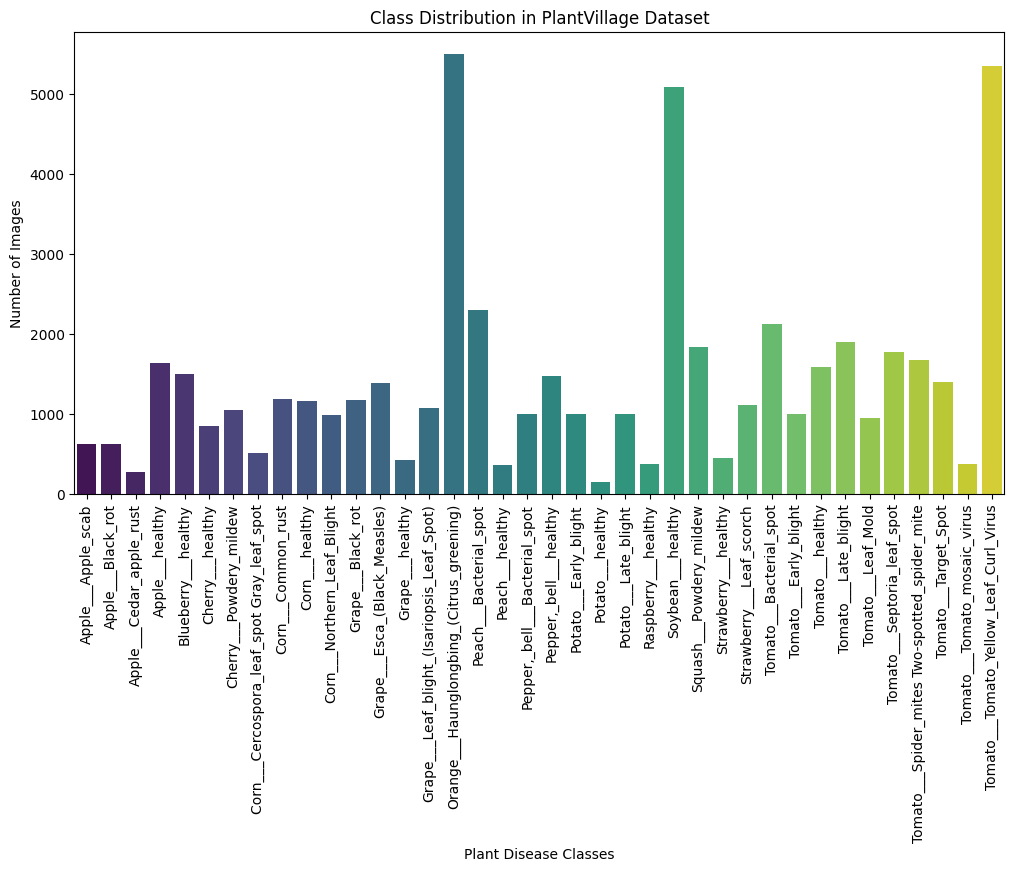

In [7]:
import collections

# Count the number of images per class
label_counts = collections.defaultdict(int)

for image, label in tfds.as_numpy(dataset["train"]):
    label_counts[label] += 1

# Convert to list for plotting
labels, counts = zip(*sorted(label_counts.items()))
labels = [class_names[i] for i in labels]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=labels, y=counts, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Plant Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in PlantVillage Dataset")
plt.show()

# Sample Visualization with Labels

We will now display a sample number of the images with the corrected labels

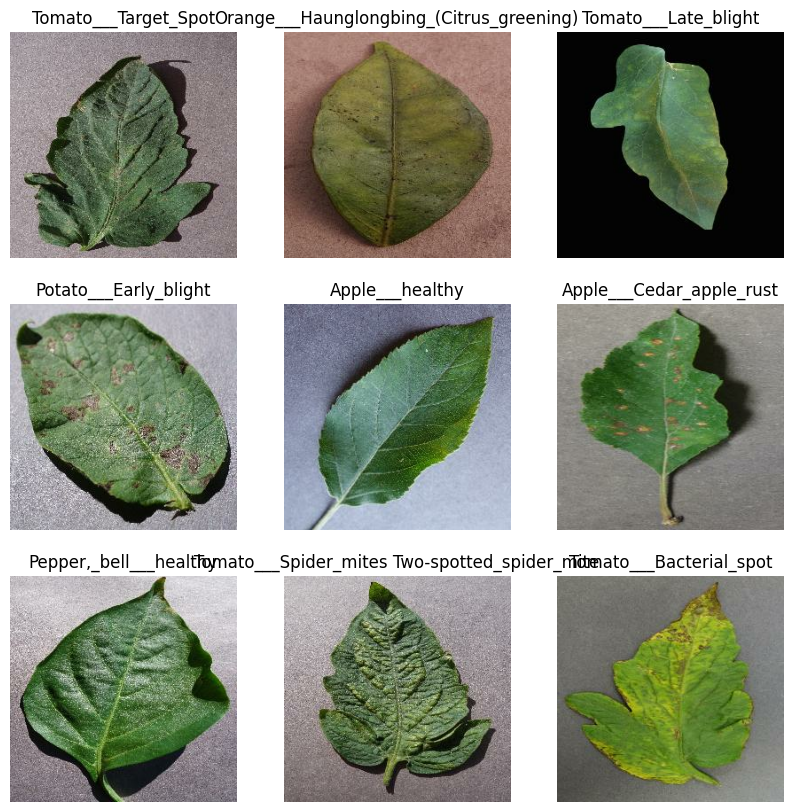

In [6]:
# Function to plot sample images
def plot_samples(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))

    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[label.numpy()])
        plt.axis("off")

    plt.show()

# Show sample images
plot_samples(dataset["train"], class_names)

# ResNet-50

ResNet-50 (Residual Network with 50 layers) is a deep convolutional neural network (CNN) designed for image classification and feature extraction.

Key Features:
- 50 Layers Deep
- Uses Residual Learning with skip connections (identity shortcuts) to mitigate vanishing gradients.
- Pretrained on ImageNet, which contains 1.2M images across 1,000 classes.
Effective for transfer learning, as it learns general visual representations.

Achitecture:
- Conv1: 7x7 convolution + Max Pooling
- 4 Residual Blocks:
  - Conv2_x (3 layers)
  - Conv3_x (4 layers)
  - Conv4_x (6 layers)
  - Conv5_x (3 layers)
- Global Average Pooling
- Fully Connected Layer (Softmax activation)

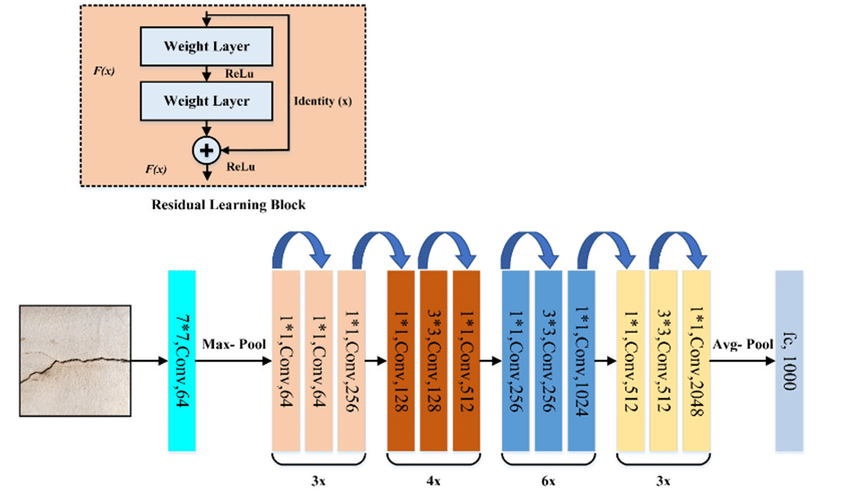

In [65]:
num_classes = info.features['label'].num_classes  # Get number of classes

# Preprocessing function
def preprocess(image, label, image_size=(224, 224)):
    image = tf.image.resize(image, image_size) / 255.0  # Resize & Normalize
    label = tf.one_hot(label, num_classes)  # One-hot encode labels
    return image, label

# Function to prepare dataset
def prepare_dataset(ds, batch_size=32):
    return (ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
              .shuffle(1000)  # Shuffle dataset
              .batch(batch_size)  # Group into batches
              .prefetch(tf.data.AUTOTUNE))  # Optimize loading

In [66]:
# Split into train & validation sets
train_size = 0.8  # 80% training, 20% validation
train_ds = dataset['train'].take(int(len(dataset['train']) * train_size))
val_ds = dataset['train'].skip(int(len(dataset['train']) * train_size))

# Create TensorFlow dataset
batch_size = 32
train_dataset = prepare_dataset(train_ds, batch_size)
val_dataset = prepare_dataset(val_ds, batch_size)

In [67]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [68]:
# Add Custom Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Define Model
model = Model(inputs=base_model.input, outputs=output)

In [69]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [70]:
# Display model summary
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,656,294 (94.06 MB)

 Trainable params: 1,068,582 (4.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [71]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

In [72]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 201s 138ms/step - accuracy: 0.1484 - loss: 3.2282 - val_accuracy: 0.2922 - val_loss: 2.6991 - learning_rate: 0.0010
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 171s 125ms/step - accuracy: 0.2706 - loss: 2.6756 - val_accuracy: 0.3571 - val_loss: 2.2964 - learning_rate: 0.0010
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 207s 129ms/step - accuracy: 0.3336 - loss: 2.3810 - val_accuracy: 0.4084 - val_loss: 2.1307 - learning_rate: 0.0010
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 166s 121ms/step - accuracy: 0.3709 - loss: 2.2317 - val_accuracy: 0.4499 - val_loss: 1.9594 - learning_rate: 0.0010
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 200s 120ms/step - accuracy: 0.3912 - loss: 2.1340 - val_accuracy: 0.4545 - val_loss: 1.8894 - learning_rate: 0.0010
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 164s 120ms/step - accuracy: 0.4119 - loss: 2.0544 - val_accuracy: 0.4902 - val_loss: 1.8208 - learning_rate: 0.0010
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 165s 120ms

## Results for first test

Here we see that the accuracy is low. This could be due to the fact the images are 128x128 instead of using 224x224. The reason i ran it this way because my gpu was timing out. The model is having a hard time generalizing the data.

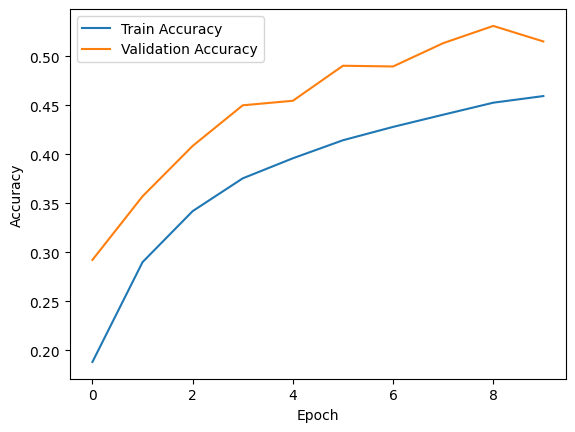

In [73]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Augmentation

- We apply random flip, contrast, and brightness to augment the images
- Images are resized to 224x224
- Color Jitter: adjusting the color channels of the images

In [74]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)  # Random contrast
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    return image, label


In [75]:
def resize_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resizing to 224x224
    return image, label

In [76]:
train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

## ResNet50 after augmentation

We are using a pretrained model and freezing the layers. That is why we use "False" in the code above.

While new layers are added we are using it just for image classification

In [78]:
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(info.features['label'].num_classes, activation='softmax')  # Number of classes
])

In [79]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

This takes a long time to run. Please use gpu T4

In [28]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 221s 151ms/step - accuracy: 0.7566 - loss: 0.8569 - val_accuracy: 0.9327 - val_loss: 0.1922
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 162s 119ms/step - accuracy: 0.8912 - loss: 0.3262 - val_accuracy: 0.9434 - val_loss: 0.1664
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 201s 119ms/step - accuracy: 0.9057 - loss: 0.2909 - val_accuracy: 0.9506 - val_loss: 0.1423
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 220s 162ms/step - accuracy: 0.9111 - loss: 0.2760 - val_accuracy: 0.9581 - val_loss: 0.1245
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 163s 120ms/step - accuracy: 0.9173 - loss: 0.2541 - val_accuracy: 0.9597 - val_loss: 0.1280
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 237s 146ms/step - accuracy: 0.9215 - loss: 0.2426 - val_accuracy: 0.9611 - val_loss: 0.1231
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 203s 146ms/step - accuracy: 0.9262 - loss: 0.2304 - val_accuracy: 0.9635 - val_loss: 0.1120
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 165s 119ms/step - ac

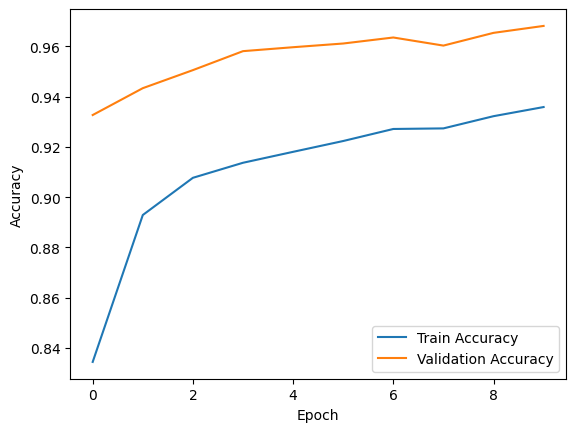

In [29]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## After Augmentation

We can see that the val_accuracy improved much more after augmenting the data. This could also be due to resizing the image 224x224 and allowing the the model to learn better with the different augmentation methods.

## Segmentation



In [165]:
# Get the class names and number of classes
class_names = info.features["label"].names
num_classes = len(class_names)

# Split dataset into training and validation sets
train_size = 0.8
train_ds = dataset['train'].take(int(len(dataset['train']) * train_size))
val_ds = dataset['train'].skip(int(len(dataset['train']) * train_size))

batch_size = 32

In [166]:
def process_segmentation(image, label):
    # Resize the image to the target size (224x224)
    image = tf.image.resize(image, (224, 224))  # Resize image to 224x224

    # Ensure the label has the correct shape (224, 224, 1)
    label = tf.image.resize(label, (224, 224), method='nearest')  # Resize label to match output size

    # Make sure the label has the correct channel dimension (1 channel for segmentation)
    label = tf.expand_dims(label, axis=-1)  # Add the channel dimension to the label

    label = tf.cast(label, tf.int32)  # Ensure the label is an integer (for sparse categorical cross-entropy)
    return image, label


In [169]:
def build_resnet50_unet(input_shape=(224, 224, 3), num_classes=38):  # Change num_classes based on dataset
    inputs = layers.Input(shape=input_shape)

    # ResNet-50 backbone (encoder)
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers

    # Encoder (ResNet50 backbone)
    x = base_model(inputs)

    # Decoder (Upsampling)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer (segmentation map)
    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = models.Model(inputs, output)

    return model

In [170]:
model = build_resnet50_unet(input_shape=(224, 224, 3), num_classes=num_classes)

In [171]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [172]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


ValueError: Input 0 of layer "functional_16" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, None, 224, 224, 3)

In [148]:
for images, labels in train_dataset.take(1):
    print(f'Image batch shape: {images.shape}')
    print(f'Label batch shape: {labels.shape}')

Image batch shape: (32, 32, 224, 224, 3)
Label batch shape: (32, 32, 224, 224, 3)


# Conclusions

In conclusion, the dataset was not the easiest to work on. First off, this dataset is huge consists of 38 different classes. It is possible that the dataset is biased having higher numbers of certain crops than others. For example, the number of tomatoe images were much higher than apples.

With the dataset being so large, it was necessary to subset the data in some cases but that also altered the results of the val_accuracy. Not sure if the data needs to be subsetted further or a better approach.

I notice that i did have higher accuracy score after augmenting and resizing the images back to 224x224. However, the runtime took me 10-15 mins plus. Lucklily i ran this on colab T4 gpu and my device is stronger than average.

I was not able to run the segmented model on this dataset. I am not sure but it was returning a 112x112 instead of the expected 224x224. I have tried using tf.resizing but it is having no effect.


Based on the two experiments, I found that augmenting the data returned the highest results with a val_accuracy score of .91 on average.

# References

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.